In [211]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

### Assignment 1

In [212]:
## GENERATE TOY DATASET

# Mean vectors
mean = [[2, 2], [8, 3], [3, 6]]

# Cov matrix
cov = [[1, 0], [0, 1]]

# Number of samples
n= 200

# Toy data
toy_data_1 = np.random.multivariate_normal(mean[0], cov, n)
toy_data_2 = np.random.multivariate_normal(mean[1], cov, n)
toy_data_3 = np.random.multivariate_normal(mean[2], cov, n)

label = np.repeat([0, 1, 2], n)
X = np.concatenate((toy_data_1, toy_data_2, toy_data_3), axis=0)

In [213]:
class K_Means:
    def __init__(self, K=3, max_iters=5000, tol=1e-4):
        self.K = K
        self.max_iters = max_iters
        self.tolerance = tol
        self.centroids = None
        self.labels = None


    def _init_centroids(self, X: np.ndarray) -> np.ndarray:
        # Randomly initialize centroids
        indices = np.random.choice(X.shape[0], self.K, replace=False)
        return X[indices]

    def _assign_labels(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        # Assign each data point to the closest centroid.
        distances = cdist(X, centroids, metric='euclidean')
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X: np.ndarray, labels: np.ndarray) -> np.ndarray:
        # Recompute centroids as the mean of the points in each cluster.
        centroids = np.zeros((self.K, X.shape[1]))

        for k in range(self.K):
            cluster_points = X[labels == k]

            # Avoid empty cluster
            if cluster_points.size > 0:
                centroids[k] = np.mean(cluster_points, axis=0)
            else:
                centroids[k] = X[np.random.choice(X.shape[0])]

        return centroids

    def _is_converged(self, old_centroids: np.ndarray, new_centroids: np.ndarray) -> bool:
        # Check if the algorithm has converged
        return np.allclose(old_centroids, new_centroids, atol=self.tolerance)

    def fit(self, X: np.ndarray) -> None:
        # Train K-means
        self.centroids = self._init_centroids(X)

        for _ in range(self.max_iters):
            #EM method
            self.labels = self._assign_labels(X, self.centroids) # Expectation step
            new_centroids = self._compute_centroids(X, self.labels) # Maximization step

            if self._is_converged(self.centroids, new_centroids): # Stop condition
                break

            self.centroids = new_centroids

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Predict cluster labels for new data points
        return self._assign_labels(X, self.centroids)


In [214]:
kmeans = K_Means(K=3)
kmeans.fit(X)
predicted_labels = kmeans.predict(X)

In [215]:
def visualize_clusters(X, labels, centroids):
    plt.title('KMeans Clustering Visualization')

    h = 0.05  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    from sklearn.metrics import pairwise_distances_argmin
    Z = pairwise_distances_argmin(np.c_[xx.ravel(), yy.ravel()], centroids)
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFE699', '#E6CCFF'])
    cmap_bold = ['r', 'g', 'b', 'y', 'm', 'c']

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    K = centroids.shape[0]
    markers = ['s', 'o', '^', 'D', 'v', 'P']  
    for k in range(K):
        cluster_points = X[labels == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    c=cmap_bold[k % len(cmap_bold)],
                    marker=markers[k % len(markers)],
                    edgecolor='black',
                    label=f'Cluster {k}')

    for idx, centroid in enumerate(centroids):
        plt.scatter(centroid[0], centroid[1],
                    c='yellow',
                    marker=markers[idx % len(markers)],
                    edgecolor='black',
                    s=200, label=f'Centroid {idx}')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()


def visualize_data(X, label, marker_styles=None, **kwargs):
    # Visualize toy data
    plt.title('Toy data visualization')
    if marker_styles is None:
        marker_styles = ['b^', 'go', 'rs']
        
    unique_labels = np.unique(label)
    
    for i in unique_labels:
        style = marker_styles[i % len(marker_styles)]
        X_i = X[label == i]
        plt.plot(X_i[:, 0], X_i[:, 1], style, **kwargs)

    plt.show()

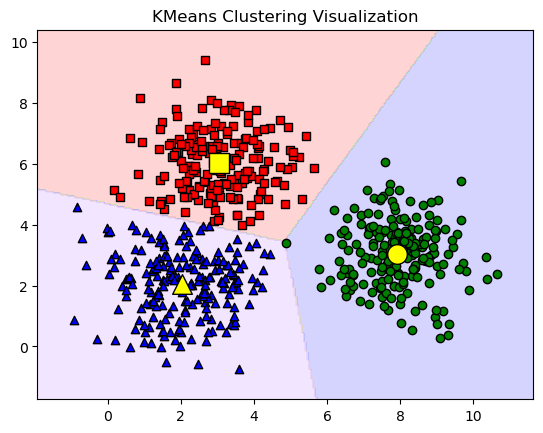

In [216]:
visualize_clusters(X, predicted_labels, kmeans.centroids)

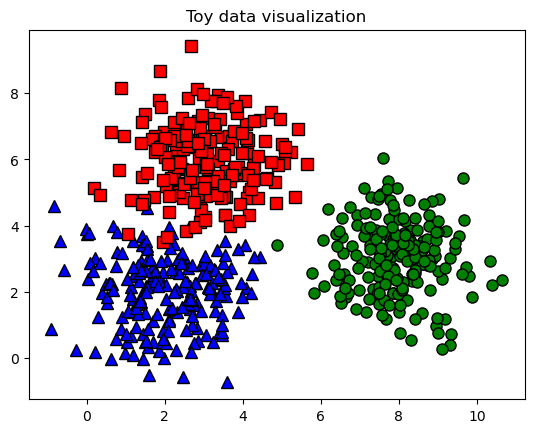

In [217]:
visualize_data(X, label, markersize=8, alpha=1, markeredgecolor='k')

In [218]:
def clustering_metrics(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    h = homogeneity_score(true_labels, predicted_labels)
    c = completeness_score(true_labels, predicted_labels)
    v = v_measure_score(true_labels, predicted_labels)

    return {
        "ARI": ari,
        "NMI": nmi,
        "Homogeneity": h,
        "Completeness": c,
        "V-measure": v,
    }


In [219]:
metrics = clustering_metrics(true_labels=label, predicted_labels=predicted_labels)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

ARI: 0.9704
NMI: 0.9549
Homogeneity: 0.9549
Completeness: 0.9550
V-measure: 0.9549


#### The Effect of Random Centroid Initialization on the Overall Performance of K-means

Random initialization of centroids can  impact both the convergence speed and the clustering quality in K-means:

##### 1. Unstable Results Due to Local Minima

- If the initial centroids are placed too close to each other, or located in sparse regions of the data,
- The algorithm may:
  - Assign points to incorrect clusters.
  - Fail to capture meaningful cluster structures in the data.

- For example, with 3 clear clusters in the data, if two initial centroids are placed in the same cluster, the algorithm may return only 2 clusters instead of 3.


##### 2. Slower Convergence
- When the initial centroids are far from the actual cluster centers, the algorithm may require **more iterations** to converge, as the centroids gradually shift toward better positions.
- For example, if centroids start far from any actual data clusters, they will slowly drift inward, taking many iterations.

### Assignment 2

In [220]:
## GENERATE TOY DATASET

# Mean vectors
mean = [[2, 2], [8, 3], [3, 6]]

# Cov matrix
cov = [[1, 0], [0, 1]]

# Number of samples
N = [50, 20, 1000]

# Toy data
toy_data_1 = np.random.multivariate_normal(mean[0], cov, N[0])
toy_data_2 = np.random.multivariate_normal(mean[1], cov, N[1])
toy_data_3 = np.random.multivariate_normal(mean[2], cov, N[2])

label = np.repeat([0, 1, 2], N)
X = np.concatenate((toy_data_1, toy_data_2, toy_data_3), axis=0)

In [221]:
kmeans = K_Means(K=3)
kmeans.fit(X)
predicted_labels = kmeans.predict(X)

In [222]:
metrics = clustering_metrics(true_labels=label, predicted_labels=predicted_labels)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

ARI: 0.0949
NMI: 0.1738
Homogeneity: 0.4077
Completeness: 0.1104
V-measure: 0.1738


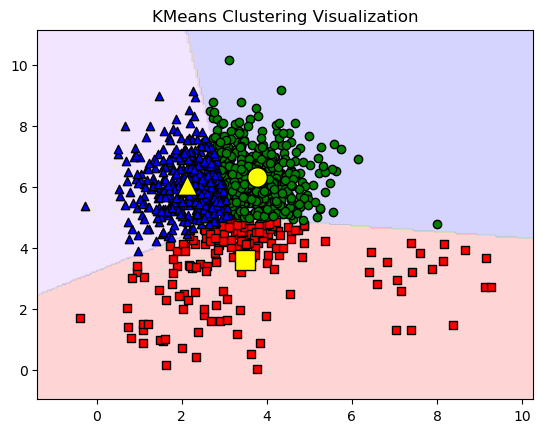

In [223]:
visualize_clusters(X, predicted_labels, kmeans.centroids)

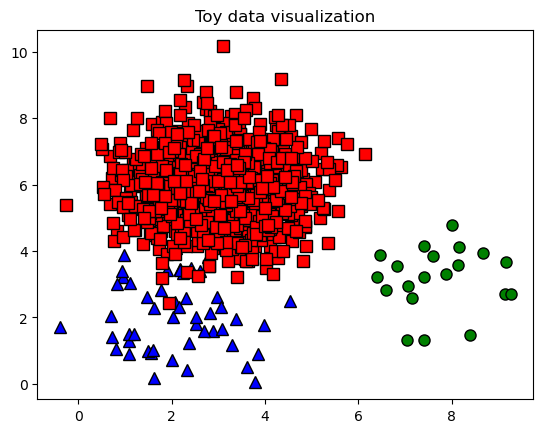

In [224]:
visualize_data(X, label, markersize=8, alpha=1, markeredgecolor='k')

#### The effect of different sizes among clusters to the performance of K-means N = [50, 20, 1000]

##### Bias Toward Larger Clusters
- K-means minimizes overall variance, which means it tends to prioritize larger clusters.

- Cluster with 1000 points will dominate the centroid movement and error minimization. Its centroid is likely to be more accurately located because of the high number of points.

- In contrast, centroids of smaller clusters (N = 20, 50) may be pulled toward larger neighboring clusters, resulting in inaccurate centroid placement. These smaller clusters may be merged into larger clusters or have their points misassigned due to the imbalance.


### Assignment 3

In [225]:
### Assignment 2
## GENERATE TOY DATASET

# Mean vectors
mean = [[2, 2], [8, 3], [3, 6]]

# Cov matrix
cov_1 = [[1, 0], [0, 1]]
cov_2 = [[10, 0], [0, 1]]

# Number of samples
N = [200, 200, 200]

# Toy data
toy_data_1 = np.random.multivariate_normal(mean[0], cov_1, N[0])
toy_data_2 = np.random.multivariate_normal(mean[1], cov_1, N[1])
toy_data_3 = np.random.multivariate_normal(mean[2], cov_2, N[2])

label = np.repeat([0, 1, 2], N)
X = np.concatenate((toy_data_1, toy_data_2, toy_data_3), axis=0)


In [226]:
kmeans = K_Means(K=3)
kmeans.fit(X)
predicted_labels = kmeans.predict(X)

In [227]:
metrics = clustering_metrics(true_labels=label, predicted_labels=predicted_labels)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

ARI: 0.6874
NMI: 0.7154
Homogeneity: 0.7020
Completeness: 0.7293
V-measure: 0.7154


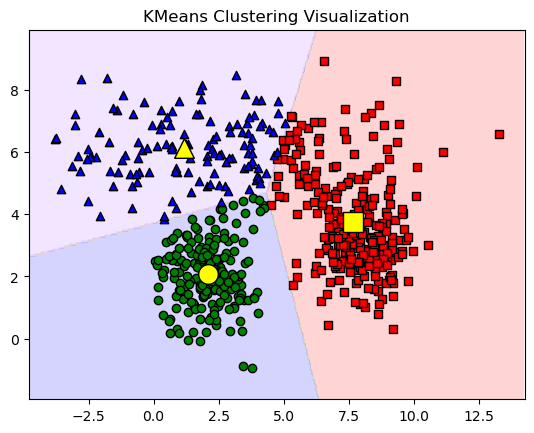

In [228]:
visualize_clusters(X, predicted_labels, kmeans.centroids)

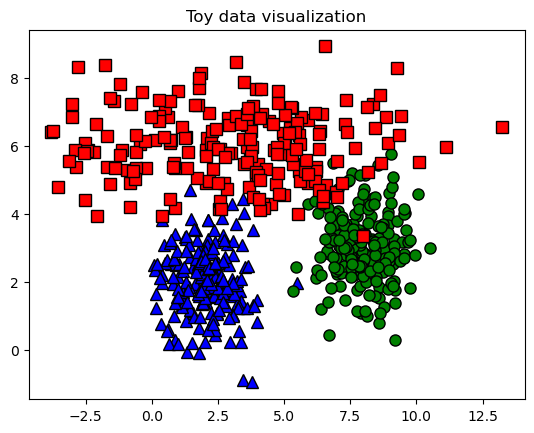

In [229]:
visualize_data(X, label, markersize=8, alpha=1, markeredgecolor='k')

#### The effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.

##### The covariance matrix $\Sigma_2$ negatively impacts K-Means clustering by introducing anisotropy and cluster overlap.
- The high variance along the x-axis in $\Sigma_2$ causes the cluster centered at $(3,6)$ to stretch horizontally.
- This leads to overlap with other clusters, making it difficult for K-Means to correctly separate them and define accurate cluster boundaries.
- While, 2 remaining clusters with with $\Sigma_2$ have similar shapes and distinct centers, so they do not overlap.